### Preprocessing

In [63]:
# Import modeling and preprocessing modules

import pandas as pd
import numpy as np
import spacy
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer, MWETokenizer
from nltk.util import ngrams
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk
from nltk.corpus import stopwords, wordnet, words
set(stopwords.words('english'))
from sklearn.feature_extraction import text
import pickle
import scipy.sparse
import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF

from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
# Import previously saved pickle

listing_reviews = pd.read_pickle("listing_reviews_pickle.p")

In [3]:
listing_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 571363 entries, 0 to 571362
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   listing_id            571363 non-null  int64  
 1   name                  571363 non-null  object 
 2   description           570502 non-null  object 
 3   date                  571363 non-null  object 
 4   accommodates          571363 non-null  int64  
 5   price                 571363 non-null  object 
 6   reviewer_id           571363 non-null  int64  
 7   listing_url           571363 non-null  object 
 8   latitude              571363 non-null  float64
 9   longitude             571363 non-null  float64
 10  review_scores_rating  571363 non-null  float64
 11  comments              571363 non-null  object 
dtypes: float64(3), int64(3), object(6)
memory usage: 56.7+ MB


In [4]:
# Sample subset of review data set to reduce resource requirements for later steps

listings_reviews_sampled = listing_reviews.sample(n=90000, random_state = 42)

In [5]:
# Save sampled "reviews" data frame to pickle file for convenient import at later checkpoints

listings_reviews_sampled.to_pickle("listing_reviews_sampled_pickle.p")

In [6]:
# Remove numbers, capital letters, punctuation, extra blank spaces, etc.

alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
remove_non_english_chars = lambda x: re.sub('[^a-zA-Z0-9_]', ' ', x)
extra_space = lambda x: re.sub('!{2,}', ' ', x)

listings_reviews_sampled["comments"] = listings_reviews_sampled["comments"].map(alphanumeric).map(punc_lower).map(remove_non_english_chars).map(extra_space)

In [7]:
listings_reviews_sampled.head(5)

,listing_id,name,description,date,accommodates,price,reviewer_id,listing_url,latitude,longitude,review_scores_rating,comments
124963,5339955,5 Minute Walk to Magic Sands Beach!,Aloha and Mahalo for your Interest! After a ye...,2016-12-10,2,$89.00,104544109,https://www.airbnb.com/rooms/5339955,19.59095,-155.96812,4.94,i had an amazingly restorative and fun time at...
512254,35583943,"810 BEAUTIFUL WOOD, AMAZING PARADISE","LEGALLY ZONED vacation rental, located at 246...",2019-10-01,3,$112.00,75330556,https://www.airbnb.com/rooms/35583943,21.26915,-157.81717,4.63,very convenient location to beach food and tr...
401581,23597857,Waikiki Partial Ocean view unit w/free parking,Waikiki Partial Ocean view w/free parking<br /...,2018-05-04,6,$185.00,70062527,https://www.airbnb.com/rooms/23597857,21.27444,-157.81988,4.88,family of infant stayed at shioris place ...
505782,34483553,Kan House,"Whether you are adventuring solo, honeymoon, o...",2019-09-29,2,$66.00,257804818,https://www.airbnb.com/rooms/34483553,21.31452,-157.85379,4.70,great central location in a local neighborhood
6705,74862,Oceanview Surfrider Entire 1 Bedroom Apartment,"Scenic unobstructed sea views, steps away from...",2012-05-23,4,$173.00,1845157,https://www.airbnb.com/rooms/74862,20.72916,-156.45055,4.71,we stayed weeks at carolyn s apartment and h...


In [64]:
# Set custom stopwords

custom_stopwords = ["hawaii", "airbnb", "bnb", "oahu", "honolulu", "island", "big", "a", "aa", "aaa",
                   "moloka", "ahu", "kau", "ni", "ihau", "i", "kaho", "olawe", "lana", "maui", "hawai",
                   "good", "great", "perfect", "br", "amazing", "recommend", "place", "like", "nice",
                   "room", "stay", "overall", "really", "check", "host", "unit", "did", "didn", "day",
                   "night", "just", "super", "famly", "location", "love", "loved", "days",
                    "definitely", "wonderful", "reservation", "arrival", "s"]
final_stopwords = text.ENGLISH_STOP_WORDS.union(custom_stopwords)

In [9]:
# Obtain reviews only from the dataframe and lemmatize with NLTK

reviews = listings_reviews_sampled["comments"]

def remove_duplicate_chars(token):
    duplicates = re.compile(r"(\w*)(\w)\2(\w*)")
    replacement = r'\1\2\3'
    def replace(word):
        if wordnet.synsets(word):
            return word
        new_word = duplicates.sub(replacement, word)
        return replace(new_word) if new_word != word else new_word
    return replace(token)

def lemmatize_text(review):
    lemmatizer = WordNetLemmatizer()
    my_phrase = review.split()
    lemmatized = ""
    for i in my_phrase:
        if i not in custom_stopwords:
            lemmatized += " " + lemmatizer.lemmatize(remove_duplicate_chars(i))
    return lemmatized[1:]

In [10]:
reviews.map(lemmatize_text)

124963    had an amazingly restorative and fun time at p...
512254     very convenient to beach food and transportation
401581    family of infant stayed at shioris in may wa m...
505782                        central in local neighborhood
6705      we stayed week at carolyn s apartment and had ...
                                ...                        
96679     wow what experience we stayed in the king bedr...
402411    this is to would live here if could frank is s...
442157    it s spacious convenient and ha all the basic ...
509066                           to close to beach and shop
440323    excellent with parking beautiful excellent com...
Name: comments, Length: 90000, dtype: object

In [11]:
# Save preprocessed reviews data to pickle file for convenient import at later checkpoints

reviews.to_pickle("reviews_preprocessed_pickle.p")

In [12]:
reviews

124963    i had an amazingly restorative and fun time at...
512254    very convenient location to beach  food and tr...
401581    family of      infant stayed at shioris place ...
505782      great central location in a local neighborhood 
6705      we stayed   weeks at carolyn s apartment and h...
                                ...                        
96679     wow  what a great airbnb experience  we stayed...
402411    this is a great place to stay  i would live he...
442157    it s spacious  convenient  and has all the bas...
509066         great place to stay close to beach and shops
440323    excellent location with parking  beautiful  ex...
Name: comments, Length: 90000, dtype: object

#### Vectorization

In [13]:
reviews = pd.read_pickle("reviews_preprocessed_pickle.p")

In [14]:
# Create Count Vectorizer and TF-IDF variables

count_vectorizer = CountVectorizer(stop_words = final_stopwords, max_df = 0.8, ngram_range=(1,2))
reviews_cv = count_vectorizer.fit_transform(reviews)

In [15]:
tf_idf = TfidfVectorizer(stop_words = final_stopwords, max_df = 0.8, ngram_range=(1,2))
reviews_tf_idf = tf_idf.fit_transform(reviews)

In [16]:
reviews_cv.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [17]:
reviews_tf_idf.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [18]:
# Save these matrices for easier loading in case of crash

scipy.sparse.save_npz("reviews_cv.npz", reviews_cv)

In [19]:
scipy.sparse.save_npz("reviews_tf_idf.npz", reviews_tf_idf)

### Modeling

In [20]:
# Function to display topic modeling results

def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

#### Latent Semantic Analysis (LSA)

In [21]:
# Test with Count Vectorizer first using various component values (3 to 10)

lsa_cv = TruncatedSVD(5)
doc_topic = lsa_cv.fit_transform(reviews_cv)
lsa_cv.explained_variance_ratio_

array([0.01930496, 0.00960742, 0.00690954, 0.00550167, 0.0049896 ])

In [22]:
topic_word_lsa_cv = pd.DataFrame(lsa_cv.components_.round(3),
             index = ["component_1","component_2","component_3","component_4","component_5"],
             columns = count_vectorizer.get_feature_names())
topic_word_lsa_cv

,aaaaaaall,aaaaaaall stars,aaaaamazing,aaaaamazing thing,aaaand,aaaand kind,aaamazing,aaamazing simply,aaand,aaand advice,...,zwart,zwart family,zwischen,zwischen einem,zz,zz shower,zzz,zzz view,zzzz,zzzz washer
component_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
component_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0
component_3,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,...,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0
component_4,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0
component_5,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0


In [23]:
display_topics(lsa_cv, count_vectorizer.get_feature_names(), 15)


Topic  0
beach, clean, condo, time, beautiful, comfortable, kitchen, house, home, close, need, walk, view, easy, area

Topic  1
house, home, clean, beautiful, comfortable, time, space, area, experience, bed, feel, staying, kitchen, property, hosts

Topic  2
condo, clean, view, pool, ocean, condo clean, parking, comfortable, easy, walking, complex, distance, restaurants, walking distance, bed

Topic  3
condo, house, beautiful, home, family, ocean, time, pool, property, lanai, feel, away, kitchen, kids, chairs

Topic  4
house, clean, condo, kitchen, house clean, condo clean, towels, bathroom, bedroom, clean comfortable, use, kids, bedrooms, spacious, equipped


In [30]:
# Test with TD-IDF using various component values (3 to 10)

lsa_tf_idf = TruncatedSVD(4)
doc_topic = lsa_tf_idf.fit_transform(reviews_tf_idf)
lsa_tf_idf.explained_variance_ratio_

array([0.00128144, 0.00508077, 0.00259536, 0.00238604])

In [31]:
topic_word_lsa_tf_idf = pd.DataFrame(lsa_tf_idf.components_.round(3),
             index = ["component_1","component_2","component_3","component_4"],
             columns = tf_idf.get_feature_names())
topic_word_lsa_tf_idf

,aaaaaaall,aaaaaaall stars,aaaaamazing,aaaaamazing thing,aaaand,aaaand kind,aaamazing,aaamazing simply,aaand,aaand advice,...,zwart,zwart family,zwischen,zwischen einem,zz,zz shower,zzz,zzz view,zzzz,zzzz washer
component_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
component_2,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
component_3,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
component_4,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,...,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0


In [32]:
display_topics(lsa_tf_idf, tf_idf.get_feature_names(), 15)


Topic  0
clean, beach, condo, view, beautiful, close, comfortable, easy, home, house, time, highly, need, space, restaurants

Topic  1
automated posting, canceled automated, automated, canceled, posting, described posting, canceled trip, canceled minute, described, exactly posting, posting enjoyed, accurate posting, posting time, clean accurate, house described

Topic  2
clean, clean comfortable, comfortable, clean quiet, clean convenient, clean spacious, condo clean, comfortable clean, spacious, house clean, clean easy, clean space, beautiful clean, clean view, spacious clean

Topic  3
view, beautiful, beautiful view, ocean, ocean view, awesome, view ocean, clean view, balcony, awesome view, view clean, view balcony, beautiful home, home, incredible


##### LSA with 4 components appears to model topics pretty well. Let's test NMF for comparison

#### Non-Negative Matrix Factorization (NMF)

In [34]:
# Again, test with Count Vectorizer first using 3 to 10 components

nmf_cv = NMF(4)
doc_topic = nmf_cv.fit_transform(reviews_cv)
topic_word_nmf_cv = pd.DataFrame(nmf_cv.components_.round(3),
             index = ["component_1","component_2","component_3","component_4"],
             columns = count_vectorizer.get_feature_names())
display_topics(nmf_cv, count_vectorizer.get_feature_names(), 15)

/Users/oppur/Desktop/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
beach, chairs, towels, walk, beach chairs, close, beach towels, right, restaurants, gear, need, boogie, boards, pool, kitchen

Topic  1
house, home, beautiful, time, kitchen, area, away, space, comfortable, little, property, need, family, view, experience

Topic  2
condo, pool, view, ocean, beautiful, time, kitchen, right, lanai, condo clean, restaurants, complex, beaches, area, enjoyed

Topic  3
clean, comfortable, easy, apartment, close, parking, waikiki, bed, space, needed, restaurants, view, clean comfortable, quiet, highly


In [56]:
# Test using TF-IDF with 3 to 10 components

nmf_tf_idf = NMF(4)
doc_topic_nmf_tdidf = nmf_tf_idf.fit_transform(reviews_tf_idf)
topic_word_nmf_td_idf = pd.DataFrame(nmf_tf_idf.components_.round(3),
             index = ["component_1","component_2","component_3","component_4"],
             columns = tf_idf.get_feature_names())
topic_word_nmf_td_idf

/Users/oppur/Desktop/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


,aaaaaaall,aaaaaaall stars,aaaaamazing,aaaaamazing thing,aaaand,aaaand kind,aaamazing,aaamazing simply,aaand,aaand advice,...,zwart,zwart family,zwischen,zwischen einem,zz,zz shower,zzz,zzz view,zzzz,zzzz washer
component_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
component_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
component_3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
component_4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
display_topics(nmf_tf_idf, tf_idf.get_feature_names(), 10)


Topic  0
beach, close, condo, beautiful, time, home, easy, house, restaurants, highly

Topic  1
automated posting, canceled automated, automated, canceled, posting, described posting, canceled trip, canceled minute, described, exactly posting

Topic  2
clean, comfortable, clean comfortable, spacious, condo clean, convenient, clean spacious, clean quiet, comfortable clean, quiet

Topic  3
view, beautiful, beautiful view, ocean, ocean view, view ocean, awesome, balcony, clean view, awesome view


##### With both LSA and NMF, TF-IDF produces more interpretible results than Count-Vectorizer. However, NMF model pulls just slightly ahead of LSA. Best combination appears to be TF-IDF NMF with 4 components (topics).

#### Re-implement NMF topic models into original listings-reviews dataframe

In [47]:
topic_scores = pd.DataFrame(doc_topic_nmf_tdidf, columns = ["Convenience", "Listing Accuracy",
                                                           "Cleanliness", "Ocean View"])
reviews_with_topics = pd.merge(listings_reviews_sampled, topic_scores, left_index = True, right_index = True)
reviews_with_topics.head(10)

,listing_id,name,description,date,accommodates,price,reviewer_id,listing_url,latitude,longitude,review_scores_rating,comments,Convenience,Listing Accuracy,Cleanliness,Ocean View
6705,74862,Oceanview Surfrider Entire 1 Bedroom Apartment,"Scenic unobstructed sea views, steps away from...",2012-05-23,4,$173.00,1845157,https://www.airbnb.com/rooms/74862,20.72916,-156.45055,4.71,we stayed weeks at carolyn s apartment and h...,0.011357,0.000000,0.002840,0.000000
83239,2532566,Ocean Breeze & View Artist's Studio,"Formerly my art studio, our beautifully remode...",2017-08-17,2,$140.00,79580986,https://www.airbnb.com/rooms/2532566,19.61281,-155.97494,4.95,wonderful hosts would recommend to anyone sta...,0.020566,0.000000,0.010246,0.000000
16505,298221,Ocean Vista Suite Private Lanai Pool/Sauna/Jac...,Transient Accommodation (TA) Registration Numb...,2013-09-10,4,$195.00,8673292,https://www.airbnb.com/rooms/298221,19.70551,-155.98583,4.76,this first experience on airbnb could not have...,0.002503,0.000008,0.000000,0.000000
22798,434008,A slice of Aloha in Historic Downtown Kona Hawaii,Approved for COVID short term & 14 day quarant...,2021-05-26,2,$101.00,76232625,https://www.airbnb.com/rooms/434008,19.63668,-155.99033,4.66,great spot couldn t get more centrally locate...,0.012074,0.000012,0.000686,0.003173
72532,1960593,Kauai Palms Hotel - Ohana & Aloha,The Kauai Palms Hotel affords the budget-minde...,2019-01-21,2,$140.00,11482438,https://www.airbnb.com/rooms/1960593,21.97060,-159.36661,4.39,great location and exactly as described we fe...,0.005958,0.000000,0.001065,0.000000
30300,633307,**MAGICAL LAVA TEMPLE with EPIC Volcano Views**,* PS - You can often see the ORANGE GLOW from ...,2021-04-05,5,$132.00,189301,https://www.airbnb.com/rooms/633307,19.35018,-154.98850,4.81,a beautiful open space gazing out onto the lav...,0.001132,0.000002,0.000000,0.000006
44580,1022193,A Place in Paradise,The Place in Paradise main attractions are the...,2018-05-15,2,$79.00,6769893,https://www.airbnb.com/rooms/1022193,19.43224,-155.88866,4.80,the host canceled this reservation days befo...,0.011009,0.000000,0.000000,0.022567
63153,1633034,Cozy Jacaranda Room,NO QUARANTINE RENTALS SINCE THIS ROOM HAS NO B...,2021-06-28,2,$79.00,15900170,https://www.airbnb.com/rooms/1633034,19.44043,-155.88678,4.85,this place is such a special quiet lush hide...,0.000000,0.000000,0.244295,0.000000
71544,1943232,"Big Ocean Views, Pool, KING bed, AC, WiFi, 132","Direct OCEAN FRONT<br />Flip flops, sand betwe...",2014-09-13,2,$157.00,16880921,https://www.airbnb.com/rooms/1943232,22.05231,-159.32820,4.76,we had an amazing time wonderful little plac...,0.005205,0.000000,0.000000,0.000340
42334,942895,Honu Ohana - walk to White Sands,Just a few blocks from the ocean and beach par...,2014-06-07,2,$110.00,9599766,https://www.airbnb.com/rooms/942895,19.58984,-155.97179,4.89,what a fabulous place to stay roomy comfy g...,0.003765,0.000000,0.000000,0.000000


In [48]:
# Save the current data frame to pickle and csv as checkpoint for visualization via Streamlit/Tableau

reviews_with_topics.to_pickle("reviews_with_topics_pickle.p")
reviews_with_topics.to_csv("reviews_with_topics.csv")

In [49]:
reviews_with_topics["review_scores_rating"].describe()

count    14185.000000
mean         4.759654
std          0.162026
min          4.000000
25%          4.660000
50%          4.790000
75%          4.870000
max          5.000000
Name: review_scores_rating, dtype: float64

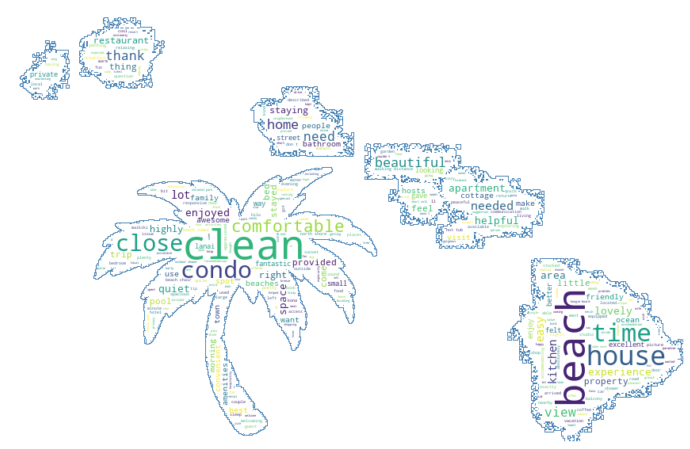

In [99]:
# Generate Word Cloud for visualization

from PIL import Image

mask = np.array(Image.open("hawaii_shape_3.png"))
text = " ".join(review for review in reviews_with_topics.comments)

wc = WordCloud(background_color = "white", mask = mask, stopwords = final_stopwords, 
              max_words = 400, contour_width = 0.1, contour_color = "steelblue")
wc.generate(text)
plt.figure(figsize=(15,8))
plt.imshow(wc, interpolation = "bilinear")
plt.axis("off")
plt.show()